<a href="https://colab.research.google.com/github/AbiemwenseMaureenOshobugie/DPhi/blob/main/Data_Sprint_101_Vessel_Image_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Sprint 101 - Vessel Image Identification
### Predict the vessel type of each image

<div align="center" style="width: 950px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://www.shutterstock.com/image-photo/container-ship-vessel-cargo-carrier-600w-1457257346.jpg"
     alt="Dummy image 1"
     style="float: center; padding-bottom=0.5em"
     width=950px/>


## Problem Statement

Detection of ships or vessels can be used for an array of purposes, including maritime safety, fisheries management, marine pollution, defence and maritime security, protection from piracy, illegal immigration, etc.

 

An agency of the Governmental Maritime and Coastguard is planning to implement an automated system based on computer vision so that it can identify ship type based on images taken from survey boats. As a consultant for this project, you are responsible for developing an efficient model.

 
## Obective
Prepare a Deep Learning Model that predicts to which class of Ships an image belongs to.

## Data Description
The dataset features 9 different classes of ships. The dataset contains about 1000+ images including the validation images. Each image has only one Ship category and are saved in separate folders of the labelled classes

For more details: click the following links, [Participants and Leaderboard](https://aiplanet.com/challenges/data-sprint-101-vessel-image-identification/318/leaderboard/public/), [Train dataset and Test dataset](https://s3.us-west-1.wasabisys.com/dphi/public-datasets/Data_Sprint_101_Vessel_Image_Identification/Dockship.zip)



## Let's Get Started!
Import Necessary Libraries

In [ ]:
!pip -q install CatBoost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.3 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import tensorflow as tf 

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, classification_report

import cv2
import os
from skimage import io
from google.colab.patches import cv2_imshow

In [ ]:
!wget https://s3.us-west-1.wasabisys.com/dphi/public-datasets/Data_Sprint_101_Vessel_Image_Identification/Dockship.zip


--2023-01-04 11:27:10--  https://s3.us-west-1.wasabisys.com/dphi/public-datasets/Data_Sprint_101_Vessel_Image_Identification/Dockship.zip
Resolving s3.us-west-1.wasabisys.com (s3.us-west-1.wasabisys.com)... 38.146.40.11, 38.146.40.21, 38.146.40.10, ...
Connecting to s3.us-west-1.wasabisys.com (s3.us-west-1.wasabisys.com)|38.146.40.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 302540909 (289M) [application/x-zip-compressed]
Saving to: ‘Dockship.zip’

Dockship.zip        100%[===================>] 288.53M  55.7MB/s    in 5.8s    

2023-01-04 11:27:17 (49.4 MB/s) - ‘Dockship.zip’ saved [302540909/302540909]



In [ ]:
!unzip  Dockship.zip

Archive:  Dockship.zip
  inflating: test/Image_1.jpg        
  inflating: test/Image_10.jpg       
  inflating: test/Image_100.jpg      
  inflating: test/Image_101.jpg      
  inflating: test/Image_102.jpg      
  inflating: test/Image_103.jpg      
  inflating: test/Image_104.jpg      
  inflating: test/Image_105.jpg      
  inflating: test/Image_106.jpg      
  inflating: test/Image_107.jpg      
  inflating: test/Image_108.jpg      
  inflating: test/Image_109.jpg      
  inflating: test/Image_11.jpg       
  inflating: test/Image_110.jpg      
  inflating: test/Image_111.jpg      
  inflating: test/Image_112.jpg      
  inflating: test/Image_113.jpg      
  inflating: test/Image_114.jpg      
  inflating: test/Image_115.jpg      
  inflating: test/Image_116.jpg      
  inflating: test/Image_117.jpg      
  inflating: test/Image_118.jpg      
  inflating: test/Image_119.jpg      
  inflating: test/Image_12.jpg       
  inflating: test/Image_120.jpg      
  inflating: test/Image_121

In [ ]:
# get the label of the data
labels = pd.read_csv("/content/Training_set.csv") # loading the labels
labels.head() # will display the first five rows in labels dataframe


,filename,label
0,Image_1.jpg,cruise_ship
1,Image_2.jpg,gondola
2,Image_3.jpg,buoy
3,Image_4.jpg,sailboat
4,Image_5.jpg,ferry_boat


In [ ]:
# Loading the order of the image's name that has been provided
test_image_order = pd.read_csv("/content/Testing_set.csv")
test_image_order.head()


,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
labels['label'].unique()


array(['cruise_ship', 'gondola', 'buoy', 'sailboat', 'ferry_boat',
       'inflatable_boat', 'kayak', 'paper_boat', 'freight_boat'],
      dtype=object)

In [ ]:
labels['label'].value_counts()


sailboat           272
kayak              142
gondola            135
cruise_ship        134
ferry_boat          44
buoy                37
paper_boat          22
freight_boat        16
inflatable_boat     11
Name: label, dtype: int64

In [ ]:
# images filepath for train
file_paths = [[fname, '/content/train/' + fname] for fname in labels['filename']]

# images filepath for test
file_path_test = [[fname, '/content/test/' + fname] for fname in test_image_order['filename']]

In [ ]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
  print('Number of labels in train set:', len(labels), 'matches the number of filenames:', len(file_paths))
else:
  print('Number of labels does not match the number of filenames')

# Confirm if number of images is same as number of labels given
if len(test_image_order) == len(file_path_test):
  print('Number of image names in test set:', len(test_image_order), 'matches the number of file paths:', len(file_path_test))
else:
  print('Number of image names does not match the number of filepaths')

Number of labels in train set: 813 matches the number of filenames: 813
Number of image names in test set: 349 matches the number of file paths: 349


In [ ]:
# convert the filepaths to dataframe
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])

# convert filepath for test to dataframe
test_images = pd.DataFrame(file_path_test, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/test/Image_1.jpg
1,Image_2.jpg,/content/test/Image_2.jpg
2,Image_3.jpg,/content/test/Image_3.jpg
3,Image_4.jpg,/content/test/Image_4.jpg
4,Image_5.jpg,/content/test/Image_5.jpg


In [ ]:
# combine labels with images
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()


,filename,filepaths,label
0,Image_1.jpg,/content/train/Image_1.jpg,cruise_ship
1,Image_2.jpg,/content/train/Image_2.jpg,gondola
2,Image_3.jpg,/content/train/Image_3.jpg,buoy
3,Image_4.jpg,/content/train/Image_4.jpg,sailboat
4,Image_5.jpg,/content/train/Image_5.jpg,ferry_boat


Let's Have a Glimpse of Some Images from Train and Test sets

(960, 1280, 3)


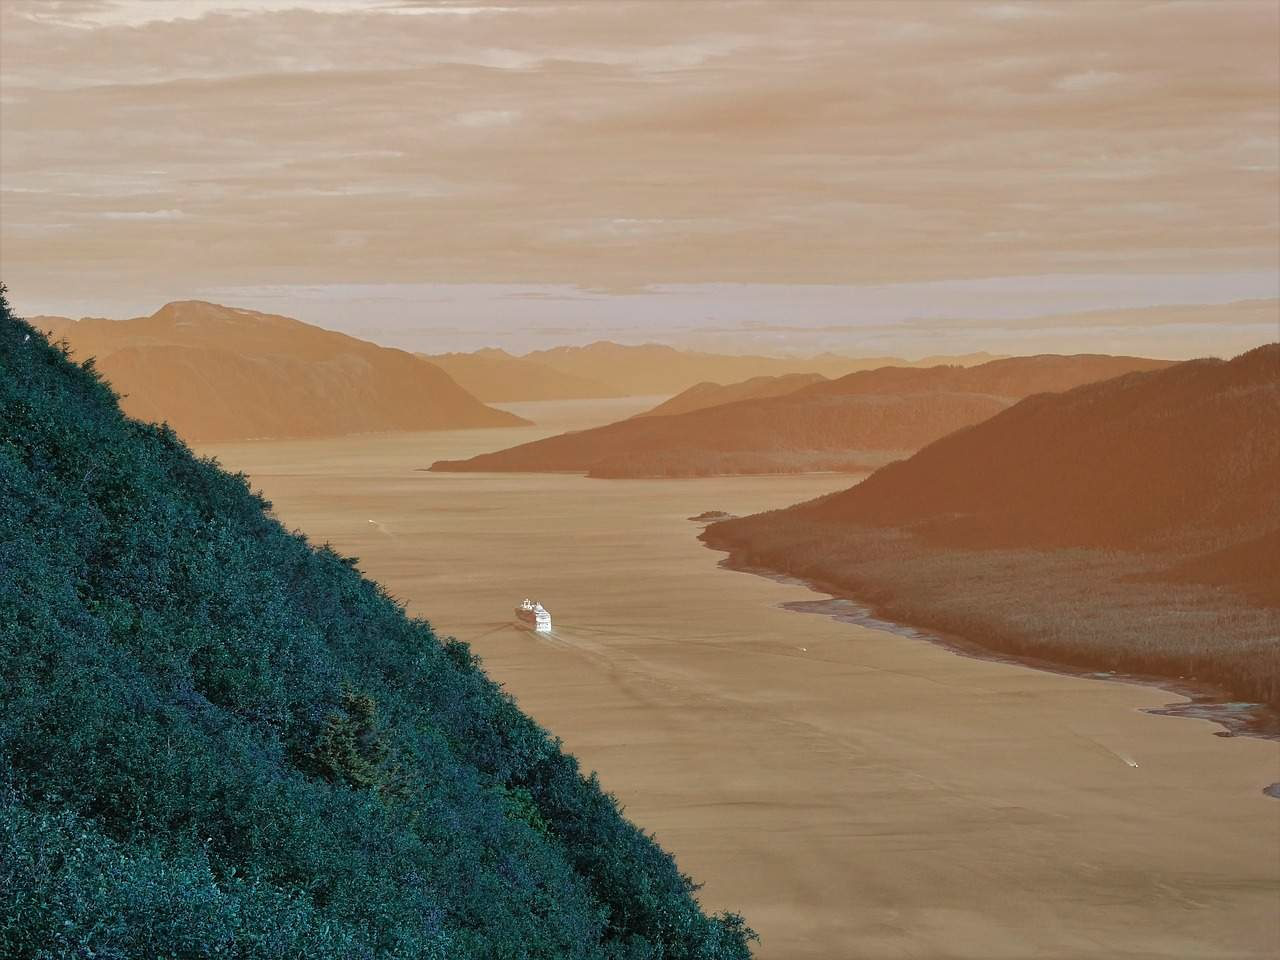

In [ ]:
img_path1 = "/content/train/Image_1.jpg"
Image_test = io.imread(img_path1,plugin='matplotlib')
print(Image_test.shape)
cv2_imshow(Image_test)

(960, 1280, 3)


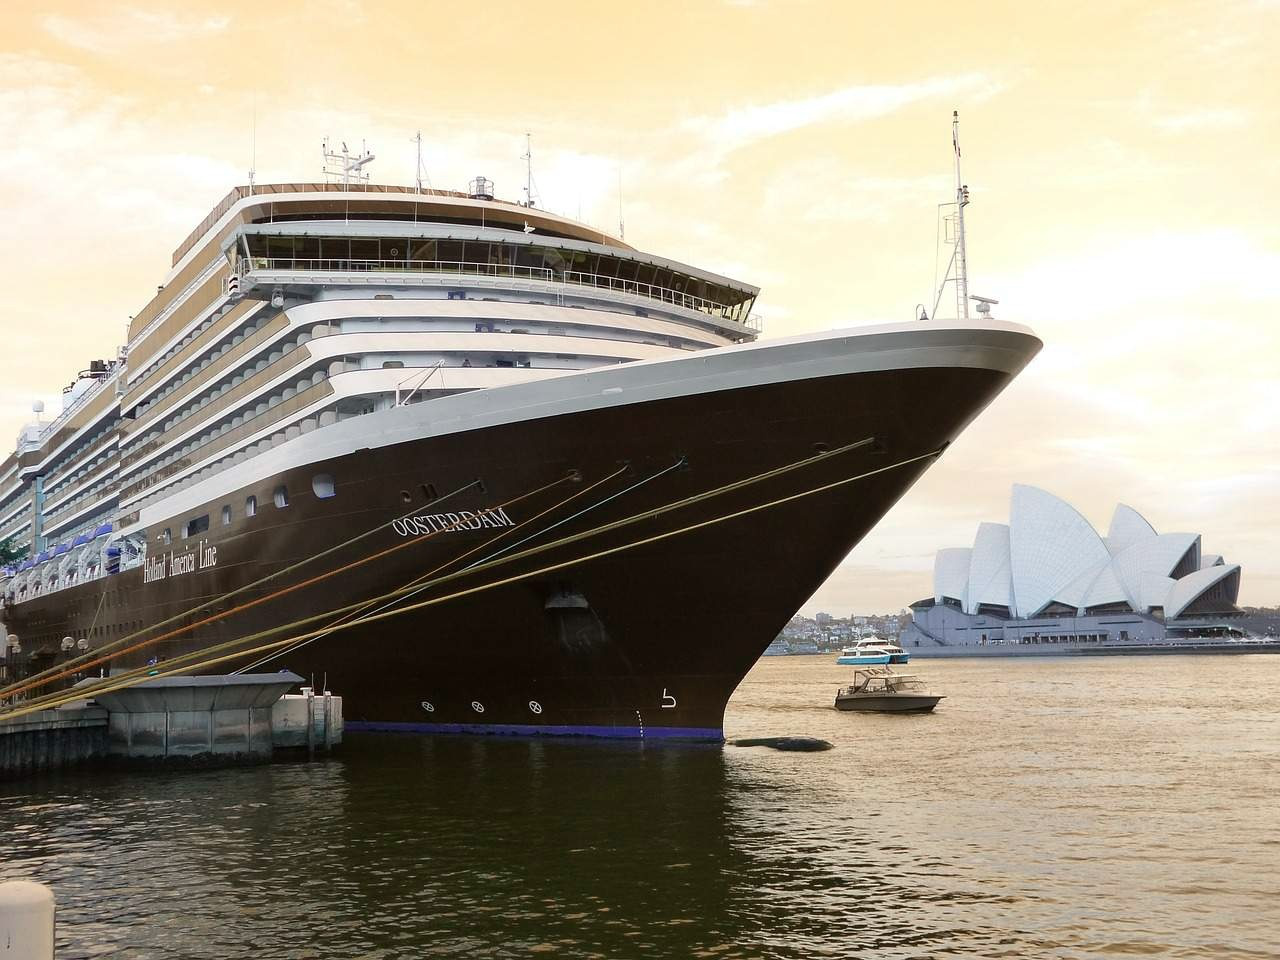

In [ ]:
img_path1 = "/content/test/Image_1.jpg"
Image_test = io.imread(img_path1,plugin='matplotlib')
print(Image_test.shape)
cv2_imshow(Image_test)

In [ ]:
le = LabelEncoder()
train_data['label'] = le.fit_transform(train_data['label'])

Preprocessing

In [ ]:
data = [] # initialize an empty numpy array
image_size = 100 # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):

  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size),cv2.INTER_AREA) # resizing the image array
  data.append([new_img_array, train_data['label'][i]])


In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 100 # image size taken is 100 here. one can take other size too
missing_files = []
for i in range(len(test_images)):
  img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)


In [ ]:
# image pixels of a image
data[5]


[array([[ 74,  26, 137, ...,  86,  62,  23],
        [ 93,  63,  54, ...,  97,  22,  22],
        [107,  75,  70, ...,  60,  21,  21],
        ...,
        [135, 108, 128, ..., 243,  44,  26],
        [110, 156, 132, ...,  84, 132,  36],
        [107, 131, 129, ...,  22,  27,  50]], dtype=uint8), 5]

In [ ]:
# shuffle the data
np.random.shuffle(data)


In [ ]:
# separate images and label 
x = []
y = []
for image in data:
  x.append(image[0])
  y.append(image[1])

In [ ]:
# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)


In [ ]:
test_pixel_data = np.array(test_pixel_data)


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 37, 134,  44,  16, 135,  11, 142,  22, 272]))

In [ ]:
# reshape the independent variable (x)
x_reshaped = x.reshape(-1, 100, 100, 1)
# reshape the test data
test_pixel_data_reshaped = test_pixel_data.reshape(-1, 100, 100, 1)

In [ ]:
# split data into train and test
X_train, X_val, y_train, y_val = train_test_split(x_reshaped,y,test_size=0.2, random_state = 42)

In [ ]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(650, 100, 100, 1) (163, 100, 100, 1) (650,) (163,)


Building Model


Convolutional Neural Network (CNN)

In [ ]:
import keras
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", verbose=1, patience=50, mode="min", restore_best_weights=True
)

callback = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=45, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=50,
        verbose=2,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    ),
]


In [ ]:
cnn = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(100, 100, 1)),

tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

# tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(9, activation='softmax')
])


In [ ]:
cnn.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

aug = tf.keras.preprocessing.image.ImageDataGenerator(
          rotation_range=40,
          zoom_range=0.2,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          horizontal_flip= True,
          vertical_flip= False,
          fill_mode="nearest"
          )

In [ ]:
history = cnn.fit(aug.flow(X_train, y_train, batch_size=32), validation_data = (X_val,y_val), epochs=200, callbacks=[early_stopping])


Epoch 1/200
21/21 [==============================] - 42s 2s/step - loss: 43.5102 - accuracy: 0.2585 - val_loss: 2.0182 - val_accuracy: 0.2393
Epoch 2/200
21/21 [==============================] - 46s 2s/step - loss: 1.8171 - accuracy: 0.3123 - val_loss: 1.8647 - val_accuracy: 0.3436
Epoch 3/200
21/21 [==============================] - 48s 2s/step - loss: 1.7866 - accuracy: 0.3415 - val_loss: 1.8603 - val_accuracy: 0.3558
Epoch 4/200
21/21 [==============================] - 45s 2s/step - loss: 1.8510 - accuracy: 0.3154 - val_loss: 1.8569 - val_accuracy: 0.3681
Epoch 5/200
21/21 [==============================] - 42s 2s/step - loss: 1.8255 - accuracy: 0.3585 - val_loss: 1.8618 - val_accuracy: 0.3865
Epoch 6/200
21/21 [==============================] - 42s 2s/step - loss: 1.8608 - accuracy: 0.3538 - val_loss: 1.8868 - val_accuracy: 0.2699
Epoch 7/200
21/21 [==============================] - 37s 2s/step - loss: 1.7950 - accuracy: 0.3154 - val_loss: 1.8625 - val_accuracy: 0.3558
Epoch 8/200


Validate the model


In [ ]:
cnn.evaluate(X_val, y_val)


6/6 [==============================] - 2s 345ms/step - loss: 1.5013 - accuracy: 0.5153


[1.5012617111206055, 0.5153374075889587]

Plot History of Training and Validation

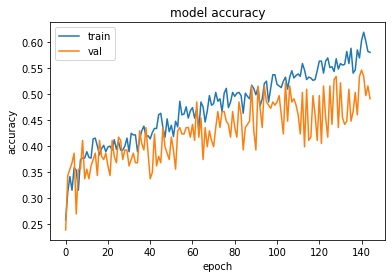

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Confusion Matrix and Classification Report

In [ ]:
pred_val = cnn.predict(X_val)

# convert prediction into respective classes, by using np.argmax.
predict_val = []
for value in pred_val:
  predict_val.append(np.argmax(value))

#  confusion matrix, classification report and accuracy score of validation set
print(confusion_matrix(predict_val,y_val))
print(classification_report(predict_val,y_val))
print(accuracy_score(predict_val,y_val))  

6/6 [==============================] - 2s 352ms/step
[[ 0  0  0  0  1  0  0  0  0]
 [ 0 15  0  1  2  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  2  2  0 18  2  6  0  7]
 [ 0  0  0  0  0  0  0  0  0]
 [ 6  1  1  1  0  2 14  2  8]
 [ 0  0  0  0  0  0  0  0  0]
 [ 3  7  5  1  4  2  8  2 37]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.60      0.71      0.65        21
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.72      0.49      0.58        37
           5       0.00      0.00      0.00         0
           6       0.50      0.40      0.44        35
           7       0.00      0.00      0.00         0
           8       0.67      0.54      0.60        69

    accuracy                           0.52       163
   macro avg       0.28      0.24      0.25       163
weighted avg       0.63   

Make Prediction on Test Dataset


In [ ]:
pred = cnn.predict(test_pixel_data_reshaped)

# convert prediction into respective classes, by using np.argmax.
prediction = []
for value in pred:
  prediction.append(np.argmax(value))

11/11 [==============================] - 5s 414ms/step


In [ ]:
predictions = le.inverse_transform(prediction)
predictions[:10]

array(['sailboat', 'kayak', 'sailboat', 'sailboat', 'sailboat', 'gondola',
       'sailboat', 'gondola', 'sailboat', 'kayak'], dtype=object)

Generate Submission File

In [ ]:
'''submit = pd.DataFrame({'filename': test_images['filename'], 'label': predictions})
submit.to_csv("submission.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission.csv')'''

'submit = pd.DataFrame({\'filename\': test_images[\'filename\'], \'label\': predictions})\nsubmit.to_csv("submission.csv", index = False)\n\n# To download the csv file locally\nfrom google.colab import files\nfiles.download(\'submission.csv\')'

# Part Two
SVM

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(650, 100, 100) (163, 100, 100) (650,) (163,)


In [ ]:
from sklearn.svm import SVC

# Initialize an SVM model
model = SVC(C = 10, 
            gamma = 'scale', 
            kernel = 'rbf')

# Fit the model to the training data
model.fit(X_train.reshape(650,10000), y_train)

SVC(C=10)

In [ ]:
pred = model.predict(X_test.reshape(163,10000))

In [ ]:
#evaluate the performance with confusion metrix, F1 measure, accuracy
print('SVC confusion_matrix')
print(confusion_matrix(pred,y_test))
print('SVC accuracy_score')
print(accuracy_score(pred,y_test))


SVC confusion_matrix
[[ 0  0  0  0  0  0  1  0  0]
 [ 2  5  1  0  3  0  5  0  2]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  7  1  5  0  9]
 [ 0  0  0  0  0  0  0  0  0]
 [ 3  3  3  1  4  3 13  2  6]
 [ 0  0  0  0  0  0  0  1  0]
 [ 3 17  3  2 11  1  4  1 38]]
SVC accuracy_score
0.39263803680981596


In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(
    C=30.0,
    class_weight="balanced",
    solver="newton-cg",
    multi_class="multinomial",
    n_jobs=-1,
    random_state=40,
)

# Fit the model to the training data
clf.fit(X_train.reshape(650,10000), y_train)

LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

In [ ]:
#from catboost import CatBoostClassifier

rfc = RandomForestClassifier(n_estimators = 200,
                             max_depth = 10,
                             max_features = 5,
                             criterion = 'entropy',
                             random_state = 42)

# train the model with data from tfidf transformer
rfc.fit(X_train.reshape(650,10000), y_train)


RandomForestClassifier(criterion='entropy', max_depth=10, max_features=5,
                       n_estimators=200, random_state=42)

In [ ]:
pred1 = rfc.predict(X_test.reshape(163,10000))

#evaluate the performance with confusion metrix, F1 measure, accuracy
print('Random confusion_matrix')
print(confusion_matrix(pred1,y_test))
print('Random accuracy_score')
print(accuracy_score(pred1,y_test))


Random confusion_matrix
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  3  2  0  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  8  0  2  0  6]
 [ 0  0  0  0  0  0  0  0  0]
 [ 3  3  2  0  6  3 11  2  3]
 [ 0  0  0  0  0  0  0  0  0]
 [ 6 18  3  3 11  3 13  2 45]]
Random accuracy_score
0.4110429447852761


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the random forest classifier
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split a node
    'max_features': ['sqrt', 'log2', None]  # number of features to consider when looking for the best split
}

# Create the random forest classifier
rfc = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train.reshape(650,10000), y_train)

# Print the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_:.2f}')


Fitting 5 folds for each of 144 candidates, totalling 720 fits
